# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [3]:
# %run "Git.ipynb".ipynb

In [4]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [7]:

Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [8]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [10]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [11]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
#trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [14]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [15]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_10096\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [16]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [17]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()

In [18]:
holding=Binance.get_inventory()

In [19]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100

pnl.sort_values(ascending=False,by='Price in USDT').round(2)


,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,2316.82,2024.19,1.00,-131.89,-160.74,-292.63,-12.63
BTCUSDT,601.02,1012.62,0.50,3.54,411.60,415.14,17.92
SOLUSDT,281.20,289.80,0.14,0.00,8.60,8.60,0.37
ETHUSDT,250.75,242.80,0.12,0.00,-7.94,-7.94,-0.34
JASMYUSDT,387.46,190.74,0.09,0.00,-196.72,-196.72,-8.49
TRXUSDT,76.87,158.62,0.08,-10.72,81.76,71.04,3.07
OMUSDT,526.32,116.92,0.06,0.00,-409.40,-409.40,-17.67
BBUSDT,60.18,11.40,0.01,-39.73,-48.78,-88.51,-3.82
BNBUSDT,1.14,1.28,0.00,-10.61,0.14,-10.47,-0.45
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52,-1.66


In [20]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

111

In [21]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [22]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [23]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [24]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [25]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [26]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [28]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 60af741b86e71de2d8db3b82f16b63862cc89fee)
✅ File pushed/updated successfully!


In [29]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [30]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [31]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [32]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: 6c6d9bb28e2d025809b17e45bb40a72d79e9f79f)
✅ File pushed/updated successfully!


In [33]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [34]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [35]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [36]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [37]:
# pnl_history['Total']

In [38]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [39]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [40]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [41]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [42]:
pnl_history['Total']

2024-09-23   -242.846960
2024-09-24   -351.229838
2024-09-25   -362.331965
2024-09-26   -276.632747
2024-09-27   -260.113627
                 ...    
2025-07-29   -182.604597
2025-07-30   -202.919717
2025-07-31   -252.687685
2025-08-01   -315.172524
2025-08-02   -206.946304
Name: Total, Length: 314, dtype: float64

<Axes: >

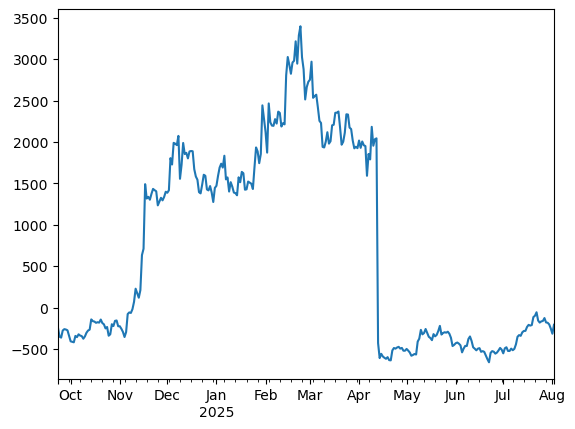

In [43]:
pnl_history['Total'].plot()

In [44]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-07-29     -3.735193
2025-07-30    -20.315121
2025-07-31    -49.767968
2025-08-01    -62.484839
2025-08-02    108.226220
Name: Total, Length: 314, dtype: float64

In [45]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-372.5258118548705, -950.5160328166933)

In [46]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [47]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [48]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [49]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [50]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [51]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [52]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

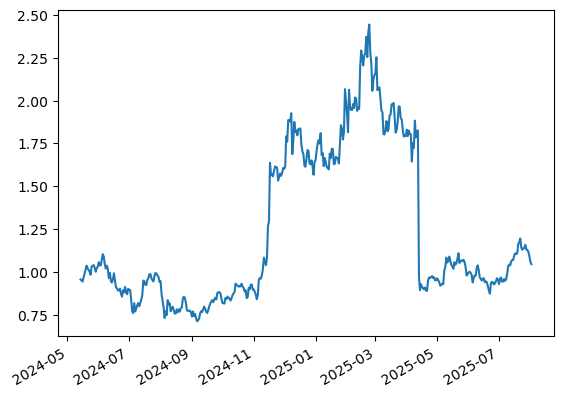

In [53]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

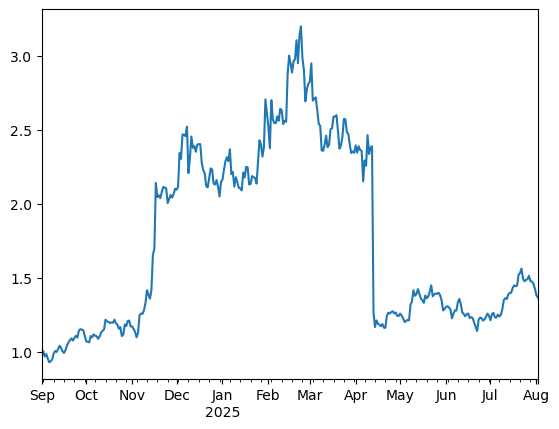

In [54]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [56]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [59]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [60]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [63]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
WBTCUSDT,0.3255
BNBUSDT,0.3090
TRXUSDT,0.1961
XRPUSDT,0.1232
OMUSDT,0.0422
SUIUSDT,0.0040
BTCUSDT,0.0000
AVAXUSDT,0.0000
LINKUSDT,0.0000
ADAUSDT,0.0000


In [64]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
WBTCUSDT,0.325511
BNBUSDT,0.309041
TRXUSDT,0.196057
XRPUSDT,0.123173
OMUSDT,0.042177
SUIUSDT,0.004041


In [65]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

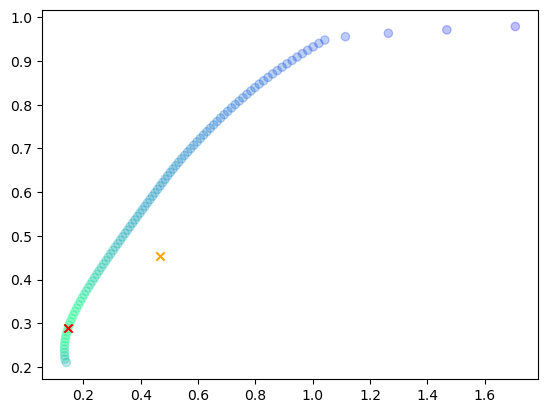

In [66]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [67]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [68]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1012.622342,0.500260,0.0471,0.453161
SOLUSDT,289.801120,0.143169,0.0000,0.143169
ETHUSDT,242.803417,0.119951,0.0000,0.119951
JASMYUSDT,190.742166,0.094231,0.0000,0.094231
TRXUSDT,158.624912,0.078365,0.0253,0.053065
OMUSDT,116.917133,0.057760,0.0053,0.052460
BBUSDT,11.396754,0.005630,0.0000,0.005630
BNBUSDT,1.282164,0.000633,0.0385,-0.037867
PEPEUSDT,0.000003,0.000000,0.0025,-0.002500
PAXGUSDT,0.000000,0.000000,0.7629,-0.762900


### Current results

In [70]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [71]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.657117
TRXUSDT,0.342883


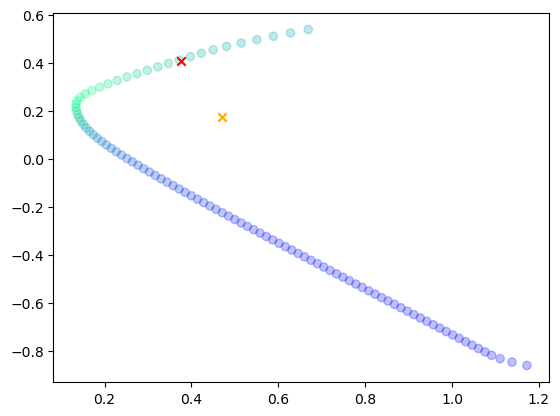

In [72]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [73]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1012.622342,0.500260,0.657117,-0.156857
SOLUSDT,289.801120,0.143169,0.000000,0.143169
ETHUSDT,242.803417,0.119951,0.000000,0.119951
JASMYUSDT,190.742166,0.094231,0.000000,0.094231
TRXUSDT,158.624912,0.078365,0.342883,-0.264518
OMUSDT,116.917133,0.057760,0.000000,0.057760
BBUSDT,11.396754,0.005630,0.000000,0.005630
BNBUSDT,1.282164,0.000633,0.000000,0.000633
PEPEUSDT,0.000003,0.000000,0.000000,0.000000


# Risk Reward Analysis

In [75]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [76]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

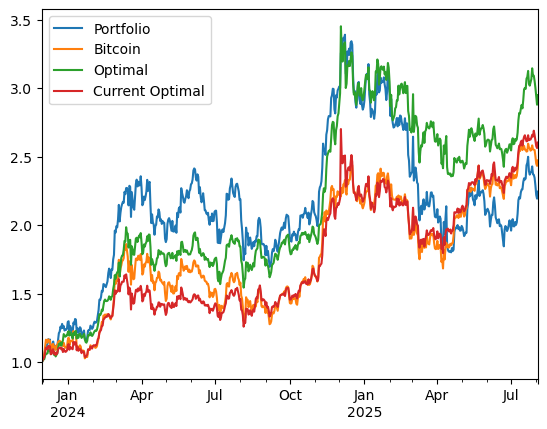

In [77]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [78]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

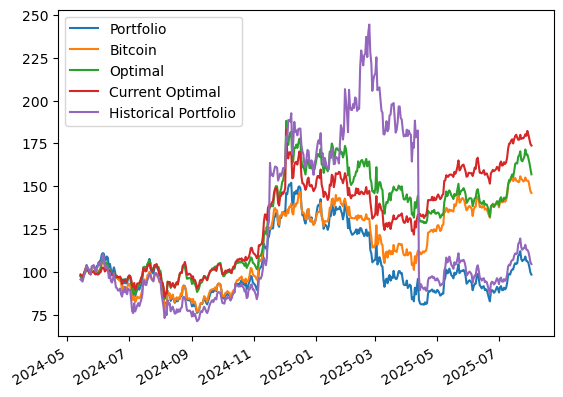

In [79]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


In [80]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-07-24,106.258806,153.712837,164.516475,178.067483,112.907479
2025-07-25,106.944453,152.766044,165.754154,177.946773,113.689748
2025-07-26,107.224147,153.162569,167.135012,178.844062,113.954313
2025-07-27,108.947372,155.092889,171.413431,180.286868,115.805181
2025-07-28,106.363820,153.325325,168.463397,179.417914,113.016330
2025-07-29,106.217914,153.180376,168.514560,182.304361,112.834387
2025-07-30,105.212205,153.036857,166.356383,180.107980,111.764598
2025-07-31,102.690717,150.316475,163.629571,177.549787,109.107870
2025-08-01,99.583247,147.079646,160.093324,174.737009,105.771308
2025-08-02,98.402215,146.100719,156.941454,173.731449,104.518910


## Volatilities

In [82]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.378308
 dtype: float64,
 0.3786149384205179)

In [83]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.470455
 dtype: float64,
 0.4704554569445742)

In [84]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.470326
Bitcoin            0.410180
Optimal            0.378615
Current Optimal    0.372609
dtype: float64

In [85]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.540599151985847

In [86]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

2.1114336343948095

In [87]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.37524931558880104

## Risk Contribution

In [89]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,49.8263,0.2941,0.1306,0.1635
WBTCUSDT,48.1018,0.2869,0.1221,0.1648
TRXUSDT,23.2631,0.1794,0.0938,0.0856
XRPUSDT,21.1067,0.1541,0.0512,0.1029
SUIUSDT,0.4148,0.0056,0.0001,0.0055
OMUSDT,-41.9240,0.0798,0.0361,0.0437
Portfolio,100.7887,1.0000,0.4340,0.5660


In [90]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,38.853959,0.545021,0.462669,0.082352
TRXUSDT,29.265354,0.454979,0.372627,0.082352
Portfolio,68.119313,1.000000,0.835296,0.164704


In [91]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
test=current_risk.perf_contrib(current_weights)

# Value At Risk

## Historical

### Optimal Weights

In [95]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.06482119898582264, -0.08241687613477724)

### Current Weights

In [97]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.08134104111181337, -0.10009918586433408)

In [98]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [99]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.019324
SOLUSDT     -0.012594
ETHUSDT     -0.009091
JASMYUSDT   -0.015337
TRXUSDT     -0.015298
OMUSDT      -0.009675
BBUSDT      -0.002231
BNBUSDT     -0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.083550
Name: 2024-12-09 00:00:00, dtype: float64

In [100]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.025906
SOLUSDT     -0.018062
ETHUSDT     -0.012265
JASMYUSDT   -0.011521
TRXUSDT     -0.004267
OMUSDT      -0.026381
BBUSDT      -0.001697
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.100099
dtype: float64

## Parametric

### Optimal Weights

In [103]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.05548455829233283, -0.06872125500462085)

### Current Weights

In [105]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.0689434319038816, -0.0853909503937615)

## Multivariate

### Optimal Weights

In [108]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05374094463098554, -0.062481870084816565)

### Current Weights

In [110]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06922941831941348, -0.08137984732405473)

In [111]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.025250
SOLUSDT     -0.012758
ETHUSDT     -0.009284
JASMYUSDT   -0.011261
TRXUSDT     -0.002713
OMUSDT      -0.005806
BBUSDT      -0.001278
Portfolio   -0.068350
dtype: float64

In [112]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.025495
SOLUSDT     -0.013499
ETHUSDT     -0.009961
JASMYUSDT   -0.012467
TRXUSDT     -0.002339
OMUSDT      -0.003900
BBUSDT      -0.001399
Portfolio   -0.069061
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [116]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.053624995701852286, -0.06225834248705921)

### Current Weights

In [118]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06793975308797116, -0.0776395973018467)

In [119]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [122]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.054353446289240236, -0.06205537955115285)

### Current Weights

In [124]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07130753531104148, -0.08080970018729834)

In [125]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [128]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.08168263400441976, -0.10147312039831333)

### Current Weights

In [130]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.09303286834754108, -0.11050618007888505)

In [131]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [134]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [135]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05576532905974246, -0.06372698030571086)

### Current Weights

In [137]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07017878670493864, -0.07952296483649875)

In [138]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [139]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.029875,-0.025180,-0.017738,-0.025250,-0.025851
SOLUSDT,-0.007907,-0.012439,-0.008844,-0.012758,-0.012695
ETHUSDT,-0.004116,-0.008941,-0.006628,-0.009284,-0.009058
JASMYUSDT,-0.008519,-0.010784,-0.008168,-0.011261,-0.010813
TRXUSDT,-0.001759,-0.002275,-0.002614,-0.002713,-0.002321
OMUSDT,-0.007182,-0.007303,-0.004897,-0.005806,-0.008058
BBUSDT,0.000176,-0.001258,-0.000860,-0.001278,-0.001287
Portfolio,-0.059182,-0.068178,-0.049750,-0.068350,-0.070083


In [140]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.029552,-0.025022,-0.017966,-0.025495,-0.026674
SOLUSDT,-0.006836,-0.013115,-0.008699,-0.013499,-0.013090
ETHUSDT,-0.004534,-0.009124,-0.006454,-0.009961,-0.009450
JASMYUSDT,-0.010331,-0.011431,-0.007878,-0.012467,-0.010479
TRXUSDT,-0.000671,-0.002624,-0.002744,-0.002339,-0.001843
OMUSDT,-0.008441,-0.006560,-0.005630,-0.003900,-0.008058
BBUSDT,0.000381,-0.001239,-0.000815,-0.001399,-0.001386
Portfolio,-0.059985,-0.069114,-0.050186,-0.069061,-0.070981


## VaR Violation

In [142]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-30,-0.032742,-0.039384,-0.035144,0.006744
2023-12-31,-0.032742,-0.039423,-0.032840,0.000333
2024-01-01,-0.032742,-0.039759,-0.034527,0.018801
2024-01-02,-0.032742,-0.039729,-0.033369,0.007485
2024-01-03,-0.032742,-0.041075,-0.035334,-0.025976
...,...,...,...,...
2025-07-30,-0.026363,-0.036093,-0.030006,-0.012807
2025-07-31,-0.026363,-0.036072,-0.031557,-0.016391
2025-08-01,-0.027639,-0.036619,-0.032722,-0.021611
2025-08-02,-0.027639,-0.037925,-0.035237,-0.019688


In [143]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.025307,-0.078175,-0.070124,-0.016099
2024-05-29,-0.018433,-0.075995,-0.066859,-0.009796
2024-05-30,-0.018433,-0.063909,-0.060337,0.022996
2024-05-31,-0.018433,-0.062521,-0.057694,0.005353
2024-06-01,-0.018433,-0.061027,-0.055069,0.017272
...,...,...,...,...
2025-07-30,-0.039266,-0.046046,-0.042744,-0.009468
2025-07-31,-0.039301,-0.046572,-0.046304,-0.023966
2025-08-01,-0.040182,-0.049051,-0.052319,-0.030260
2025-08-02,-0.040182,-0.049317,-0.052823,-0.011860


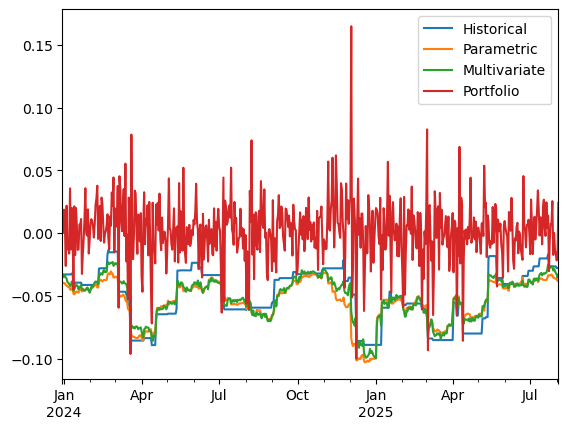

In [144]:
var_data.plot()
plt.show()

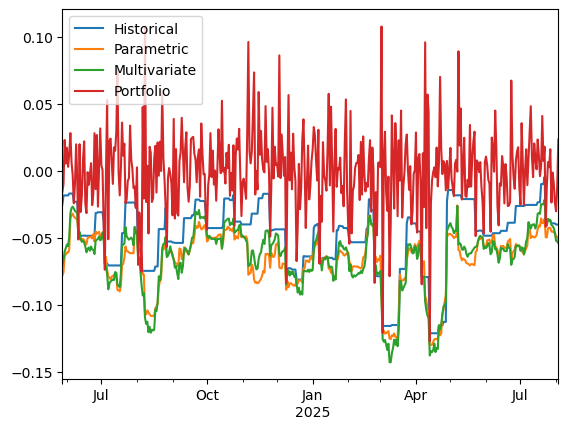

In [145]:
current_var_data.plot()
plt.show()


In [146]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.03259,0.017153,0.018868
Kupiec Stat,4.22028,17.557235,15.448082
P-value,0.039944,0.000028,0.000085


In [147]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.064665,0.018476,0.016166
Kupiec Stat,1.80168,11.819002,14.008331
P-value,0.179509,0.000586,0.000182


# Principal Component Analysis

## Historical PCA

In [150]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.5725587 , 0.23702002, 0.07886439, 0.06161165, 0.04994524])

In [151]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

ADAUSDT      0.065190
AVAXUSDT     0.065194
BCHUSDT      0.049523
BNBUSDT      0.028949
BTCUSDT      0.033616
DOGEUSDT     0.067922
ETHUSDT      0.047260
HBARUSDT     0.065829
JASMYUSDT    0.075933
LINKUSDT     0.059957
OMUSDT       0.078168
PAXGUSDT     0.000431
PEPEUSDT     0.087297
SOLUSDT      0.057621
SUIUSDT      0.063673
TRXUSDT      0.019313
USDCUSDT    -0.000172
WBTCUSDT     0.033380
XLMUSDT      0.051259
XRPUSDT      0.049658
Name: PC1, dtype: float64

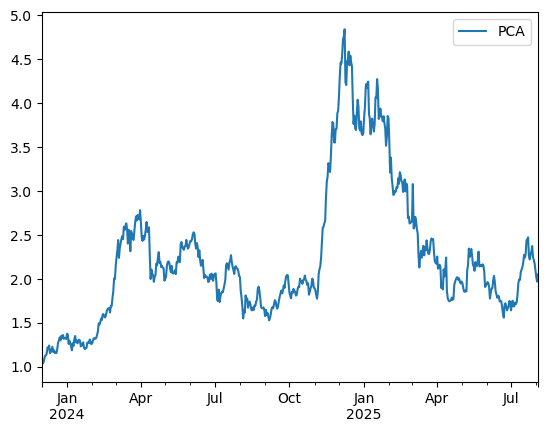

In [152]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

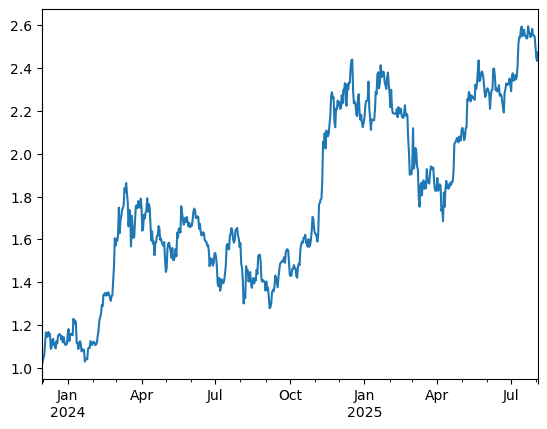

In [153]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [154]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.535794
WBTCUSDT     0.562468
BTCUSDT      0.562916
AVAXUSDT     0.671757
SOLUSDT      0.672362
LINKUSDT     0.681209
DOGEUSDT     0.694384
BNBUSDT      0.723950
ADAUSDT      0.728130
XRPUSDT      0.776106
BCHUSDT      0.845689
XLMUSDT      0.911936
USDCUSDT     0.960680
PAXGUSDT     0.975119
SUIUSDT      1.071918
TRXUSDT      1.088854
HBARUSDT     1.103287
JASMYUSDT    1.210150
PEPEUSDT     1.283717
dtype: float64

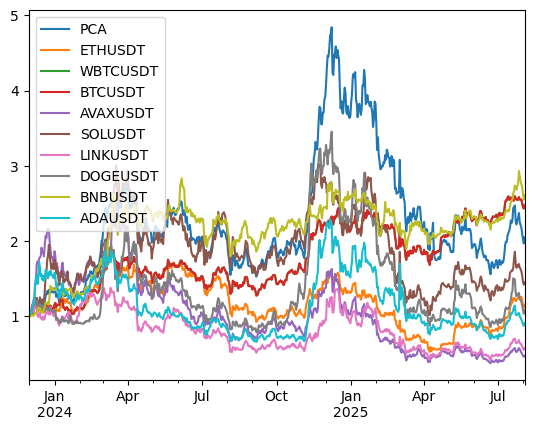

In [155]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

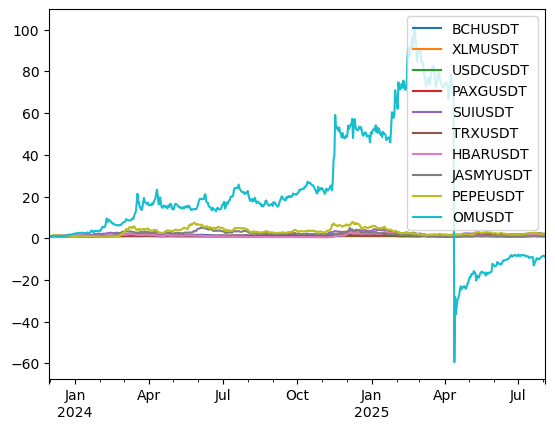

In [156]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [158]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.52399218, 0.30514799, 0.06894922, 0.05972628, 0.04218434])

In [159]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.049495
SOLUSDT      0.092027
ETHUSDT      0.079638
JASMYUSDT    0.140128
TRXUSDT      0.034702
OMUSDT       0.250003
BBUSDT       0.165723
BNBUSDT      0.050998
PEPEUSDT     0.136403
PAXGUSDT     0.000883
Name: PC1, dtype: float64

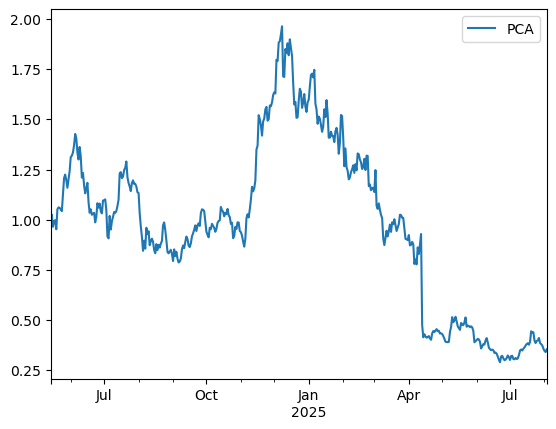

In [160]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()
plt.show()

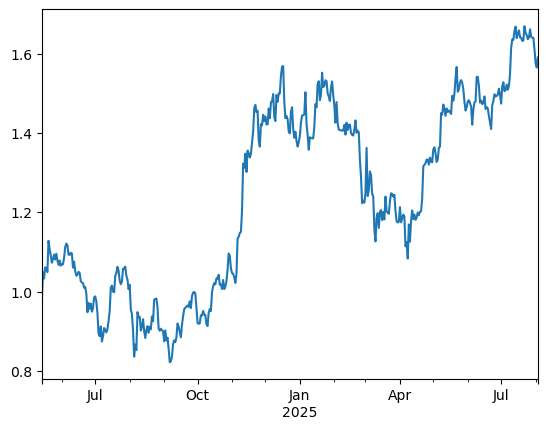

In [161]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [162]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.743414
SOLUSDT      0.781416
BTCUSDT      0.797971
BNBUSDT      0.800854
JASMYUSDT    0.984589
PEPEUSDT     1.019619
BBUSDT       1.051783
PAXGUSDT     1.054581
TRXUSDT      1.174103
dtype: float64

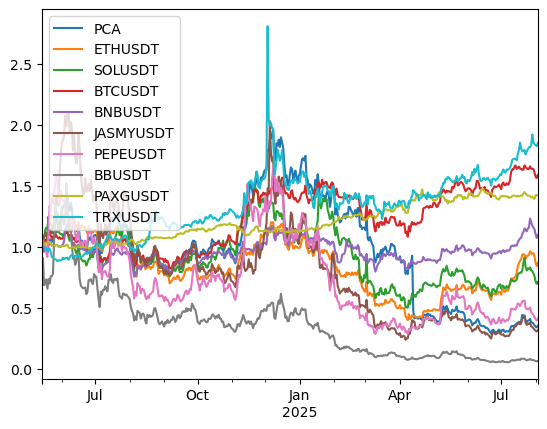

In [163]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [165]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.921100
BBUSDT       1.617169
JASMYUSDT    1.460993
SOLUSDT      1.282831
ETHUSDT      1.091744
BTCUSDT      1.000000
OMUSDT       0.989023
BNBUSDT      0.663914
TRXUSDT      0.330364
PAXGUSDT     0.027431
Name: BTCUSDT, dtype: float64

In [166]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       2.577560
PEPEUSDT     2.172676
JASMYUSDT    2.094861
SOLUSDT      1.519717
ETHUSDT      1.290458
BTCUSDT      1.000000
OMUSDT       0.942154
BNBUSDT      0.872071
TRXUSDT      0.328006
PAXGUSDT     0.040223
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [168]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [169]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.351831
JASMYUSDT,0.302046
TRXUSDT,0.159086
ETHUSDT,0.148829
BBUSDT,0.095612
SOLUSDT,0.084374
OMUSDT,0.079801
BNBUSDT,0.078473
PEPEUSDT,-0.001603
PAXGUSDT,-0.175142


### Regression to PCA

In [171]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.5727830760901336

In [172]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.326918
BNBUSDT      1.132476
PCA          1.000000
ETHUSDT      0.883118
SOLUSDT      0.735927
JASMYUSDT    0.467615
PEPEUSDT     0.461091
BBUSDT       0.385634
TRXUSDT      0.286608
PAXGUSDT     0.204508
OMUSDT       0.165932
dtype: float64

In [173]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.734700
BNBUSDT      1.232567
PCA          1.000000
ETHUSDT      0.920580
SOLUSDT      0.764217
PEPEUSDT     0.679290
JASMYUSDT    0.631472
PAXGUSDT     0.454092
BBUSDT       0.423058
TRXUSDT      0.401944
OMUSDT       0.243731
dtype: float64

### Correlation Matrix

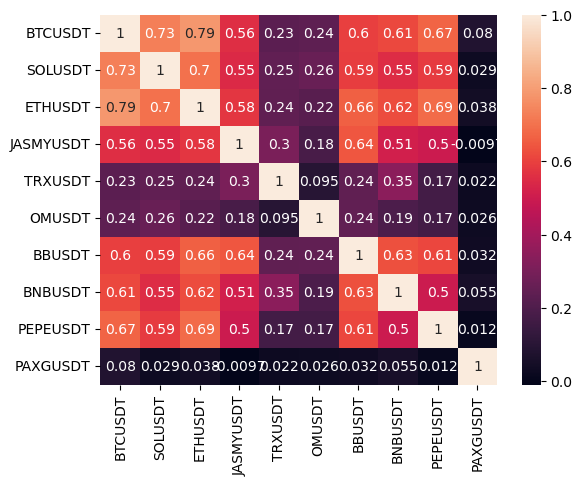

In [175]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

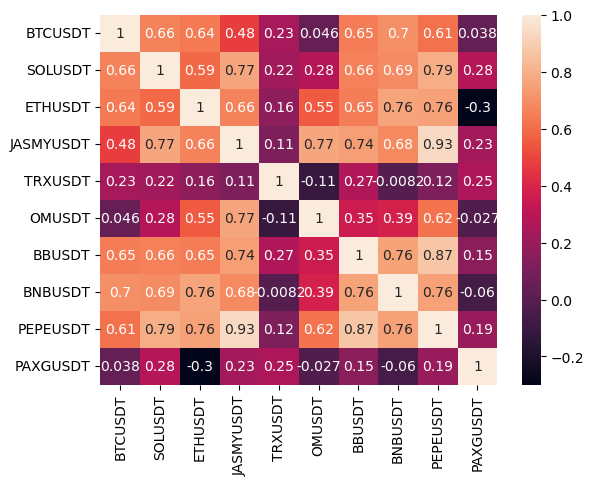

In [176]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [177]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [178]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

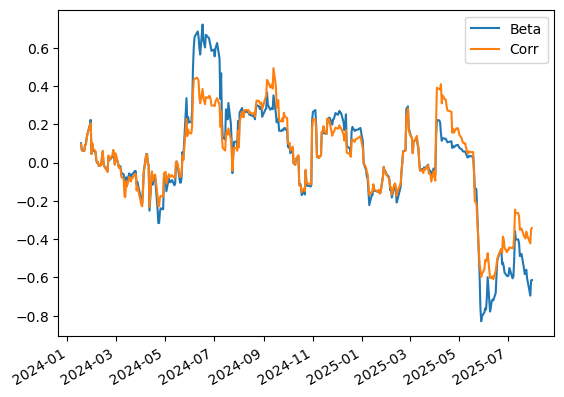

In [179]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [181]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,SOLUSDT,ETHUSDT,JASMYUSDT,TRXUSDT,OMUSDT,BBUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483879,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.000000,0.000000,0.000000,0.150876,0.222957,0.626168,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.223616,0.000000,0.003604,0.000000,0.000000,0.772780
2024-07-22,0.260704,0.086231,0.000000,0.000000,0.238042,0.019283,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.453755,0.000000,0.000000,0.000000,0.000000,0.546245
2024-09-02,0.000000,0.000000,0.000000,0.000000,0.564814,0.435186,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.000000,0.000000,0.166022,0.000000,0.526886,0.176734,0.000000,0.000000,0.130357,0.000000


In [182]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [ ]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

In [ ]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

In [ ]:
q=rebalanced_dynamic_quantities(data[returns_to_use.columns],rolling_optimization)
ptf=q*data[returns_to_use.columns]
comparison=pd.DataFrame()
comparison['BTCUSDT']=data['BTCUSDT']
comparison['Fund']=ptf.sum(axis=1)
((1+comparison.loc['2025'].pct_change()).cumprod()*100).plot()

In [ ]:
(ptf-rebalanced_book_cost(data[returns_to_use.columns],q)).iloc[-1].sort_values(ascending=False)

In [ ]:
git.create_or_replace_notebook("Prod.ipynb")